In [1]:
import tensorflow as tf

import numpy as np

train_x = np.arange(20).astype(np.float32)
train_y = 3*train_x + 1

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(100).batch(32)

for x, y in train_ds:
    print(x.shape, y.shape, '\n')

(20,) (20,) 



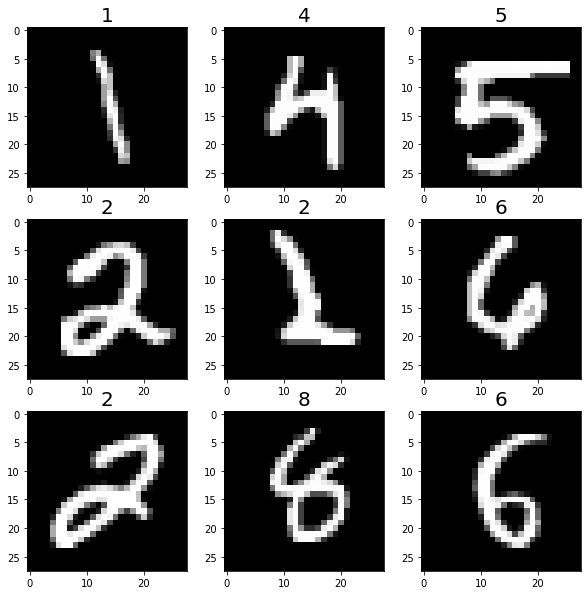

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.data import Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# print(type(train_images))
# print(train_images.shape)
# print(train_labels.shape)
# print(test_images.shape)
# print(test_labels.shape)

train_ds = Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(60000).batch(9)

test_ds = Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(9)

train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

fig, axes = plt.subplots(3, 3, figsize=(10,10))

for ax_idx, ax in enumerate(axes.flat):
    image = images[ax_idx, ...]
    label = labels[ax_idx]
    
    ax.imshow(image.numpy(), 'gray')
    ax.set_title(label.numpy(), fontsize=20)

In [4]:
import tensorflow_datasets as tfds

dataset, ds_info = tfds.load(name='mnist',
                             shuffle_files=True,
                             with_info=True)
print(ds_info)
print(ds_info.features)
print(ds_info.splits)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInf

In [7]:
EPOCHS = 10

In [8]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        conv2d = tf.keras.layers.Conv2D
        maxpool = tf.keras.layers.MaxPool2D
        self.sequence = list()
        self.sequence.append(conv2d(16, (3, 3), padding='same', activation='relu')) # 28x28x16
        self.sequence.append(conv2d(16, (3, 3), padding='same', activation='relu')) # 28x28x16
        self.sequence.append(maxpool((2,2))) # 14x14x16
        self.sequence.append(conv2d(32, (3, 3), padding='same', activation='relu')) # 14x14x32
        self.sequence.append(conv2d(32, (3, 3), padding='same', activation='relu')) # 14x14x32
        self.sequence.append(maxpool((2,2))) # 7x7x32
        self.sequence.append(conv2d(64, (3, 3), padding='same', activation='relu')) # 7x7x64
        self.sequence.append(conv2d(64, (3, 3), padding='same', activation='relu')) # 7x7x64
        self.sequence.append(tf.keras.layers.Flatten()) # 1568
        self.sequence.append(tf.keras.layers.Dense(128, activation='relu'))
        self.sequence.append(tf.keras.layers.Dense(10, activation='softmax'))

    def call(self, x, training=False, mask=None):
        for layer in self.sequence:
            x = layer(x)
        return x

In [9]:
# Implement training loop
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

# Implement algorithm test
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

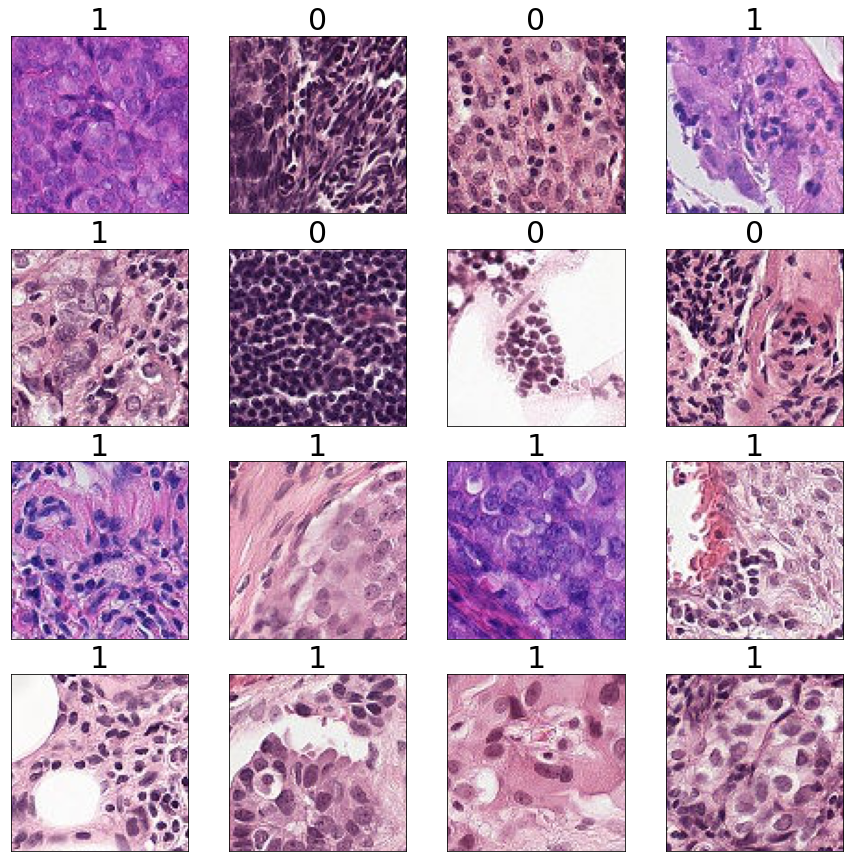

In [10]:
(train_ds, validation_ds, test_ds), ds_info = tfds.load(name='patch_camelyon',
                             shuffle_files=True,
                             as_supervised=True,
                             split=['train', 'validation', 'test'],
                             with_info=True,
                             batch_size=16)

train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

# print(images.shape)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx, ...].numpy())
    ax.set_title(labels[ax_idx].numpy(), fontsize=30)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [11]:
# Create model
model = ConvNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [12]:
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

TypeError: in user code:

    <ipython-input-9-3fc99fcd8b91>:5 train_step  *
        predictions = model(images)
    <ipython-input-8-208b39c7b35c>:21 call  *
        x = layer(x)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\layers\convolutional.py:247 call
        outputs = self._convolution_op(inputs, self.kernel)
    D:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\ops\nn_ops.py:1010 convolution_v2
        return convolution_internal(
    D:\anaconda\lib\site-packages\tensorflow\python\ops\nn_ops.py:1140 convolution_internal
        return op(
    D:\anaconda\lib\site-packages\tensorflow\python\ops\nn_ops.py:2584 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    D:\anaconda\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:975 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    D:\anaconda\lib\site-packages\tensorflow\python\framework\op_def_library.py:576 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    D:\anaconda\lib\site-packages\tensorflow\python\framework\op_def_library.py:57 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64, int32


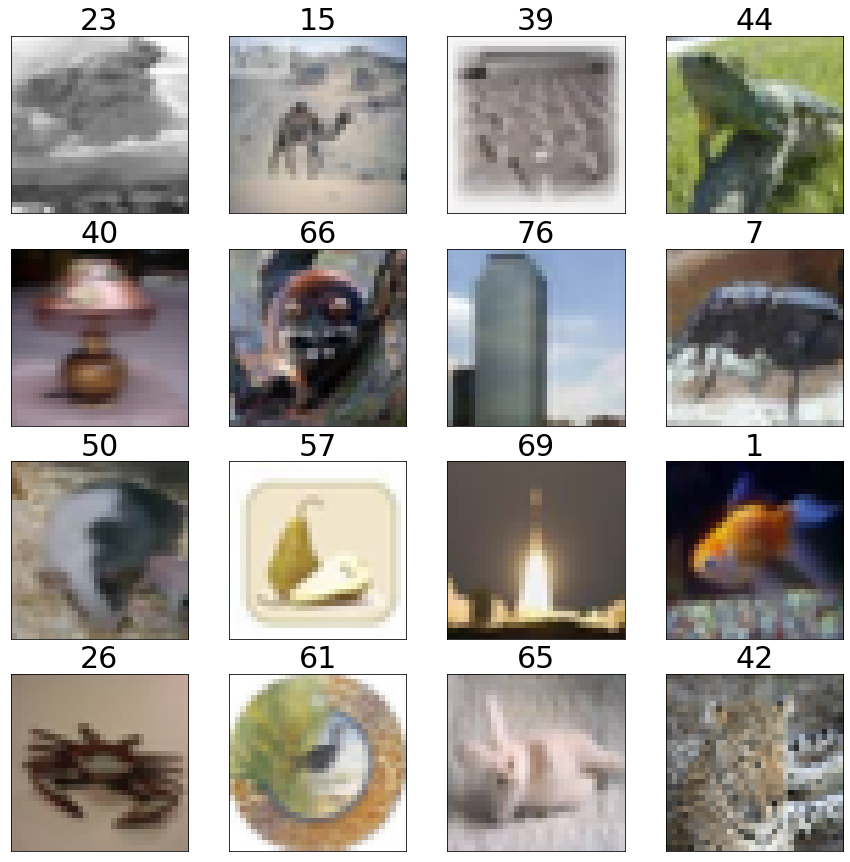

In [2]:
import tensorflow_datasets as tfds

import tensorflow as tf

import numpy as np

(train_ds,  test_ds), ds_info = tfds.load(name='cifar100',
                             shuffle_files=True,
                             as_supervised=True,
                             split=['train',  'test'],
                             with_info=True,
                             batch_size=16)

train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

# print(images.shape)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx, ...].numpy())
    ax.set_title(labels[ax_idx].numpy(), fontsize=30)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)